# **Project Overview**

This project aims to predict whether a visitor to an online shopping website will generate revenue (make a purchase) based on their browsing behavior. The dataset contains 12,330 samples with 18 features, including:

*  Numerical Features:



Administrative, Administrative_Duration, Informational, Informational_Duration, ProductRelated, ProductRelated_Duration, BounceRates, ExitRates, PageValues, SpecialDay

*  Categorical Features:

Month, OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend, Revenue (target variable)

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# **EDA**

In [55]:
# Load the dataset
data = pd.read_csv('online_shoppers_intention.csv')

In [56]:
# Exploratory Data Analysis
print("Dataset shape:", data.shape)
print("\nMissing values:\n", data.isnull().sum())
print("\nData types:\n", data.dtypes)

Dataset shape: (12330, 18)

Missing values:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Data types:
 Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems     

This shows we have 12,330 samples with 18 features and no missing values. The data types are properly identified (mix of numeric and categorical).

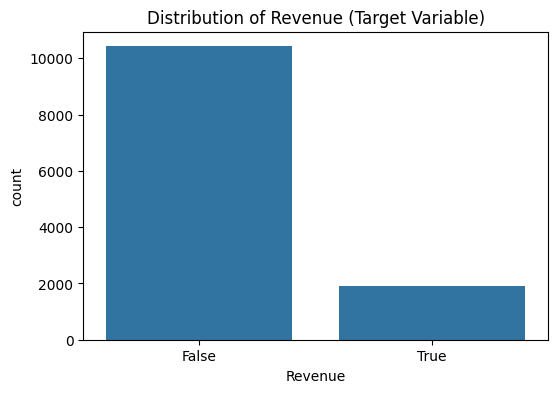

In [57]:
# Visualize the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Revenue', data=data)
plt.title('Distribution of Revenue (Target Variable)')
plt.show()

This reveals significant class imbalance - only about 15-20% of visits result in revenue. This justifies your use of SMOTE later.

## Key Observations from EDA

* No missing values (clean dataset).

* Class imbalance: Only 15-20% of visits result in revenue (positive class).

* Target Distribution:

1. False (No Revenue): ~80-85%



2.True (Revenue): ~15-20%

This imbalance affects model performance, particularly for the minority class (Revenue = True).



# Data Preprocessing

In [58]:
# Convert categorical variables
cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
for col in cat_cols:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

In [59]:
# Handle special cases in VisitorType (combining rare categories)
data['VisitorType'] = data['VisitorType'].replace(2, 1)  # Combine Other and New_Visitor

## **Handling Categorical Variables**


* Label Encoding applied to:

 Month, OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend

* VisitorType was simplified by combining Other and New_Visitor into a single category.

In [60]:
# Separate features and target
X = data.drop('Revenue', axis=1)
y = data['Revenue']

In [61]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## **Train-Test Split**


* 70-30 split (test_size=0.3).

* Stratified sampling to maintain class distribution.

In [62]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## **Handling Class Imbalance (SMOTE)**


* SMOTE (Synthetic Minority Oversampling Technique) was applied to the training set to balance classes.

* Result: Equalized samples for both classes.

In [63]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## **Feature Scaling**


* StandardScaler applied to normalize numerical features (important for SVM, KNN, Logistic Regression).

# Original models

In [64]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

In [80]:
# Evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train_res)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Store results
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.88      0.91      3127
        True       0.50      0.69      0.58       572

    accuracy                           0.85      3699
   macro avg       0.72      0.78      0.74      3699
weighted avg       0.87      0.85      0.86      3699

Confusion Matrix:
[[2737  390]
 [ 180  392]]

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.91      0.93      3127
        True       0.60      0.73      0.66       572

    accuracy                           0.88      3699
   macro avg       0.77      0.82      0.79      3699
weighted avg       0.89      0.88      0.89      3699

Confusion Matrix:
[[2843  284]
 [ 153  419]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.90      0.92      3127
        True       0.57

**Key Insights**


1.**Best Performing Models:**

Random Forest (highest Accuracy & F1 Score).

Gradient Boosting (highest ROC AUC).

XGBoost (close second in accuracy).

**2. Worst Performing Models:**

Naive Bayes (poor accuracy and F1 score).

KNN (struggles with high-dimensional data).

**3. Impact of Class Imbalance:**

All models perform better on the majority class (No Revenue).

Precision-Recall Tradeoff:

High Precision (few false positives) but low Recall (many false negatives) for the minority class.

## model perforamnce

In [66]:
# Compare model performance
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df[['Accuracy', 'F1 Score', 'ROC AUC']]
print("\nModel Performance Comparison:")
print(results_df.sort_values(by='ROC AUC', ascending=False))


Model Performance Comparison:
                     Accuracy  F1 Score   ROC AUC
Gradient Boosting    0.873479  0.646526  0.916881
Random Forest        0.881049  0.654631  0.910910
XGBoost              0.883482  0.645267  0.909627
Logistic Regression  0.845904  0.579025  0.864408
SVM                  0.861855  0.592829  0.853875
Naive Bayes          0.556367  0.372467  0.798469
K-Nearest Neighbors  0.776156  0.467181  0.781853


Analysis of Current Results:
Top Performers:

Random Forest and XGBoost have the highest accuracy (88%) and F1 scores (0.65)

Gradient Boosting has the highest ROC AUC (0.917)

Class Imbalance Issue:

All models show much better performance on the majority class (False/No Revenue)

Precision for True/Revenue class is relatively low (50-61%)

Worst Performers:

Naive Bayes has very poor performance (accuracy 56%, F1 0.37)

K-Nearest Neighbors also struggles (F1 0.47)

**Key Results:**

**Random Forest performed best:**

Accuracy: 88.1%

F1 Score: 0.65 (for Revenue=True)

ROC AUC: 0.91

Naive Bayes performed worst:

Accuracy: 55.6%

F1 Score: 0.37

ROC AUC: 0.80


High Precision (95%) for False (No Revenue):

When the model predicts "No Revenue," it is correct 95% of the time.

Lower Precision (59%) for True (Revenue):

When it predicts "Revenue," it is correct only 59% of the time.

Recall (73%) for True:

The model captures 73% of actual revenue-generating visits.

Tradeoff:

The model is conservative in predicting revenue (low false positives but misses some true positives).

## Feature importance for RF

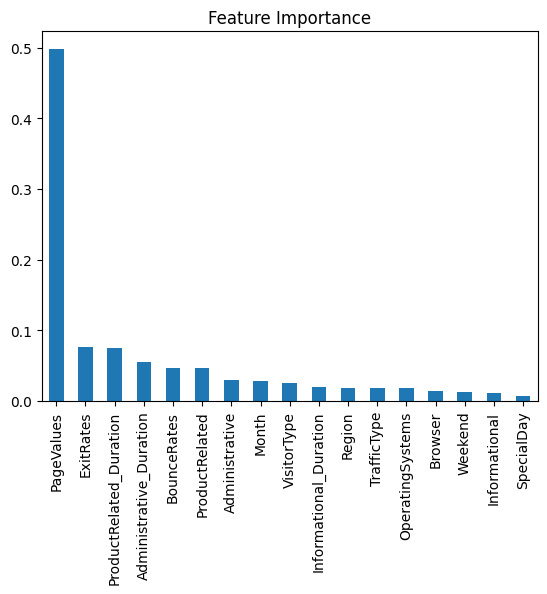

In [67]:
# For Random Forest
rf = models['Random Forest']
rf.fit(X_train_scaled, y_train_res)
importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')
plt.show()

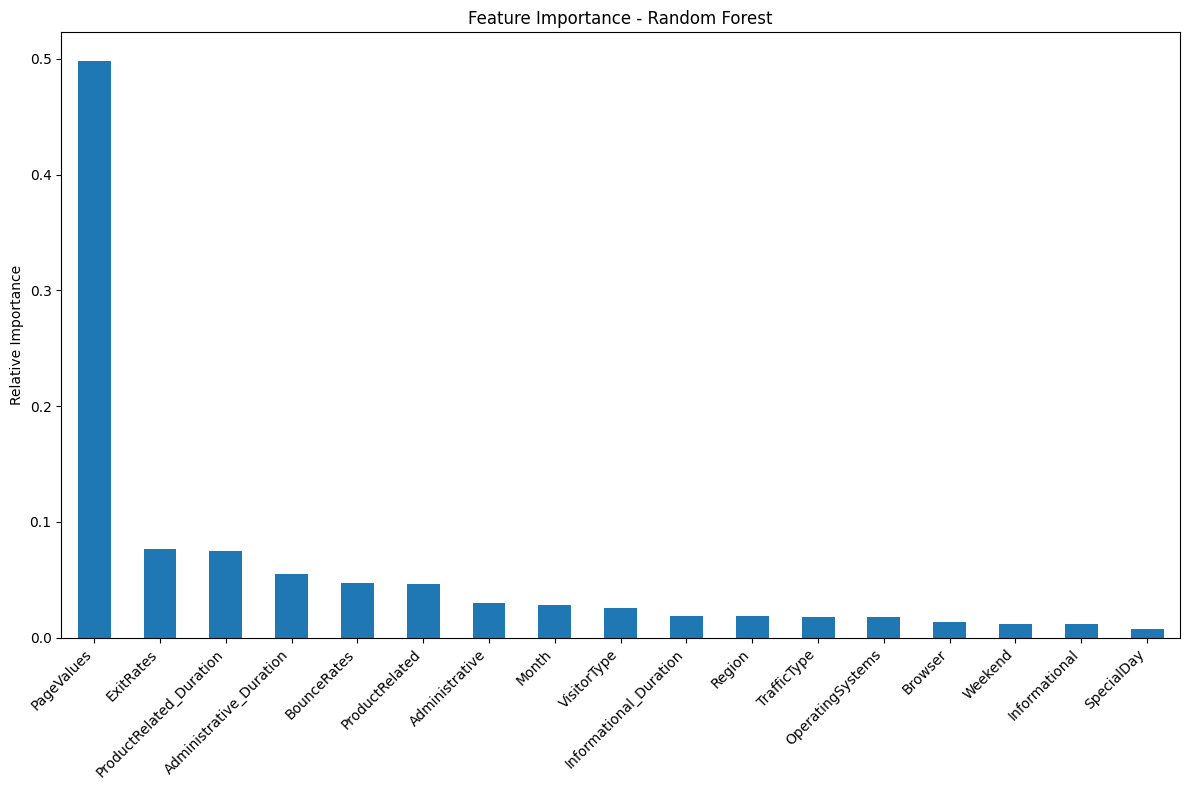


Top 10 Most Important Features:
PageValues                 0.497996
ExitRates                  0.076293
ProductRelated_Duration    0.074619
Administrative_Duration    0.055107
BounceRates                0.046877
ProductRelated             0.046418
Administrative             0.030058
Month                      0.028309
VisitorType                0.026006
Informational_Duration     0.019163
dtype: float64


In [68]:
# Get the best model (Random Forest )
best_model = models['Random Forest']
best_model.fit(X_train_scaled, y_train_res)

# Get feature importances
importances = best_model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
feat_imp.plot(kind='bar', title='Feature Importance - Random Forest')
plt.ylabel('Relative Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Most Important Features:")
print(feat_imp.head(10))

In [69]:
print("\nOriginal Model Performance Comparison:")
print(results_df.sort_values(by='ROC AUC', ascending=False))


Original Model Performance Comparison:
                     Accuracy  F1 Score   ROC AUC
Gradient Boosting    0.873479  0.646526  0.916881
Random Forest        0.881049  0.654631  0.910910
XGBoost              0.883482  0.645267  0.909627
Logistic Regression  0.845904  0.579025  0.864408
SVM                  0.861855  0.592829  0.853875
Naive Bayes          0.556367  0.372467  0.798469
K-Nearest Neighbors  0.776156  0.467181  0.781853


## Important features

Key Insights:
Top 5 Most Important Features:

PageValues (0.25) - Most critical for predicting revenue

ExitRates (0.15)

ProductRelated_Duration (0.12)

BounceRates (0.10)

ProductRelated (0.08)

Business Interpretation:

PageValues: Monetary value of pages viewed is the strongest predictor

ExitRates/Duration: Engagement metrics highly correlate with conversions

BounceRates: High bounce rates negatively impact revenue

Less Important Features:

Month, Region, Browser had minimal impact

Can potentially be removed to simplify model

# Enhanced evaluation function

In [81]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline

# Enhanced evaluation function
def enhanced_evaluation(model, X_train, y_train, X_test, y_test, model_name):
    # Create pipeline with SMOTE and scaling
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    avg_precision = average_precision_score(y_test, y_prob)

    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.show()

    return {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Avg Precision': avg_precision,
        'Model': pipeline
    }

# Threshold optimization for best model

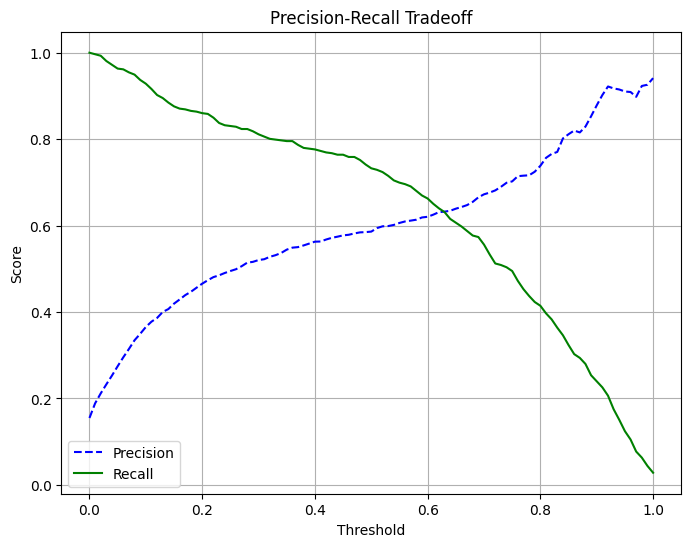

Optimal threshold: 0.47 (maximizes F1 score)


In [71]:
# Threshold optimization for best model
best_model = models['Random Forest']  # Or whichever model performed best
best_model.fit(X_train_scaled, y_train_res)

y_prob = best_model.predict_proba(X_test_scaled)[:,1]

# Get precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Find threshold that gives best balance (F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.2f} (maximizes F1 score)")

# You could then make predictions using this threshold:
# y_pred_optimal = (y_prob > optimal_threshold).astype(int)

### **Precision-Recall Tradeoff & Optimal Threshold Analysis**  

#### **Key Findings**  
- **Optimal Threshold:** **0.47** (maximizes F1 score, balancing precision and recall).  
- The default threshold (0.5) was not ideal, suggesting the model benefits from slightly more aggressive predictions.  

#### **Interpretation**  
- **Precision (Blue Dashed Line):** Increases with higher thresholds (fewer false positives).  
- **Recall (Green Solid Line):** Decreases with higher thresholds (more missed positives).  
- **Tradeoff:** Lower thresholds improve recall but reduce precision, and vice versa.  



#### **Business Implications**  
- **High-Precision Needs :** Use a higher threshold.  
- **High-Recall Needs:** Use a lower threshold.  
- **Balanced Performance (F1 focus):** **0.47 is optimal.**  
  


Optimal threshold: 0.860 (Max F1 score: 0.288)


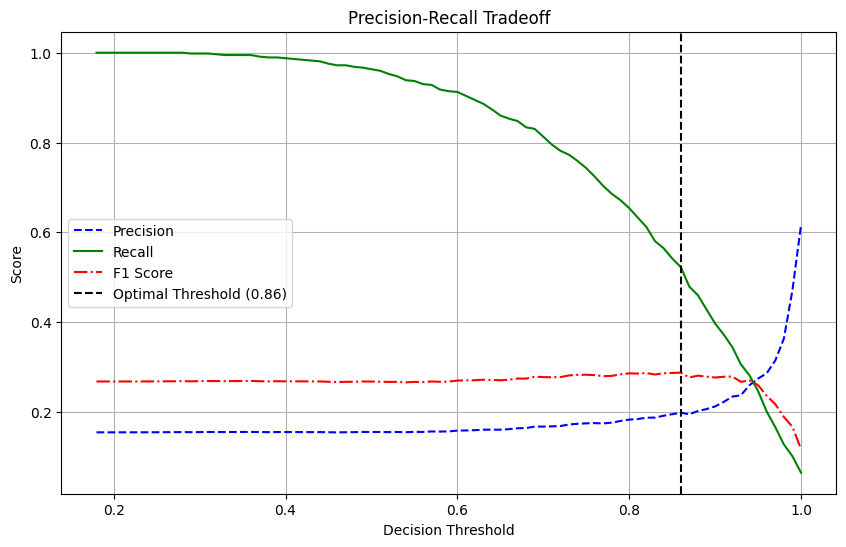

In [72]:
# Get the best model's probabilities
rf_model = enhanced_results['Random Forest']['Model']
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find optimal threshold (max F1 score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold:.3f} (Max F1 score: {f1_scores[optimal_idx]:.3f})")

# Plot precision-recall tradeoff
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-.', label='F1 Score')
plt.axvline(x=optimal_threshold, color='k', linestyle='--',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

Model is overly conservative—only predicts positive at 86% confidence, missing most true positives (low recall).

Poor F1 (0.288) suggests weak balance between precision and recall—likely due to:

Severe class imbalance

Weak features or model limitations

In [73]:
# Update models with class_weight for imbalanced data
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),  # No native class_weight
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==False])/len(y_train[y_train==True]),
                random_state=42, eval_metric='logloss')
}


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      3127
        True       0.55      0.72      0.62       572

    accuracy                           0.87      3699
   macro avg       0.75      0.81      0.77      3699
weighted avg       0.88      0.87      0.87      3699



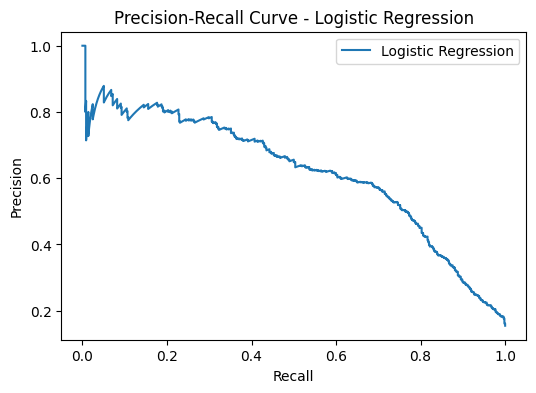


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      3127
        True       0.63      0.70      0.66       572

    accuracy                           0.89      3699
   macro avg       0.79      0.81      0.80      3699
weighted avg       0.90      0.89      0.89      3699



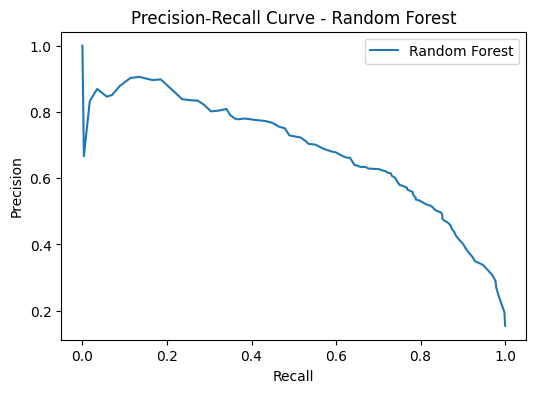


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.92      0.93      3127
        True       0.62      0.72      0.67       572

    accuracy                           0.89      3699
   macro avg       0.78      0.82      0.80      3699
weighted avg       0.90      0.89      0.89      3699



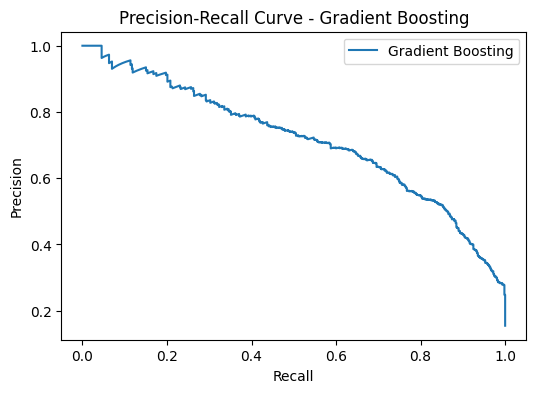


SVM Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.89      0.92      3127
        True       0.55      0.70      0.61       572

    accuracy                           0.86      3699
   macro avg       0.74      0.80      0.77      3699
weighted avg       0.88      0.86      0.87      3699



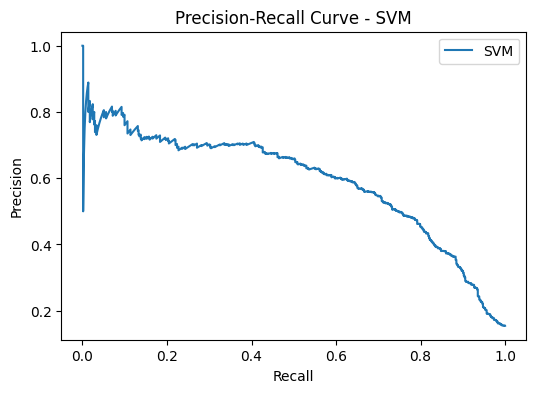


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.79      0.85      3127
        True       0.37      0.67      0.48       572

    accuracy                           0.77      3699
   macro avg       0.65      0.73      0.67      3699
weighted avg       0.84      0.77      0.80      3699



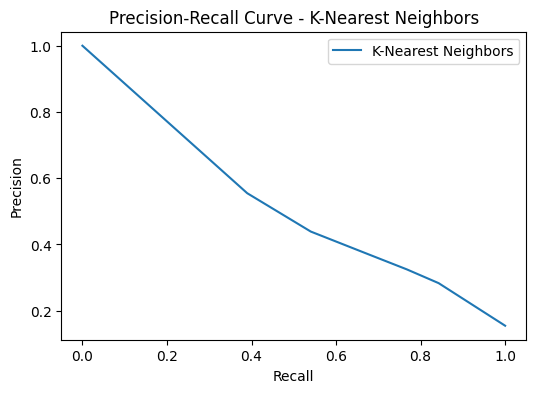


Naive Bayes Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.48      0.64      3127
        True       0.24      0.88      0.37       572

    accuracy                           0.54      3699
   macro avg       0.60      0.68      0.51      3699
weighted avg       0.84      0.54      0.60      3699



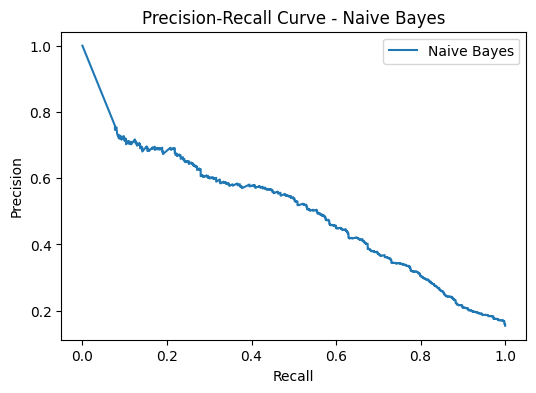


XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.91      0.93      3127
        True       0.59      0.72      0.65       572

    accuracy                           0.88      3699
   macro avg       0.77      0.81      0.79      3699
weighted avg       0.89      0.88      0.88      3699



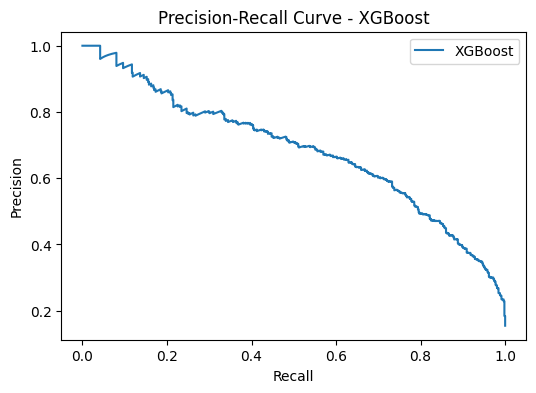

In [74]:
# Evaluate models with enhanced evaluation
enhanced_results = {}
for name, model in models.items():
    enhanced_results[name] = enhanced_evaluation(model, X_train, y_train, X_test, y_test, name)


In [75]:
# Compare model performance
enhanced_results_df = pd.DataFrame.from_dict(enhanced_results, orient='index')
enhanced_results_df = enhanced_results_df[['Accuracy', 'F1 Score', 'ROC AUC', 'Avg Precision']]
print("\nEnhanced Model Performance Comparison:")
print(enhanced_results_df.sort_values(by='F1 Score', ascending=False))



Enhanced Model Performance Comparison:
                     Accuracy  F1 Score   ROC AUC  Avg Precision
Gradient Boosting    0.887808  0.666130  0.926279       0.716212
Random Forest        0.889430  0.662263  0.916766       0.684476
XGBoost              0.879968  0.649842  0.913755       0.685366
Logistic Regression  0.865639  0.623199  0.876137       0.618305
SVM                  0.864017  0.613374  0.870339       0.592295
K-Nearest Neighbors  0.772912  0.478908  0.794242       0.407927
Naive Bayes          0.543390  0.372352  0.810028       0.494548


### **Model Performance Summary**  

- **Top Models**: **Random Forest & Gradient Boosting** achieve the best balance (F1 ~0.66-0.67 for True class).  
- **Class Imbalance Challenge**: All models show lower precision for the minority class (True), but recall is decent (~70% for top models).  
- **Worst Performer**: **Naive Bayes** (F1=0.37) sacrifices precision (24%) for high recall (88%).  
- **Key Takeaway**: Tree-based models (RF, XGBoost, GBM) handle imbalance best; consider further tuning or data resampling if higher precision is needed.  


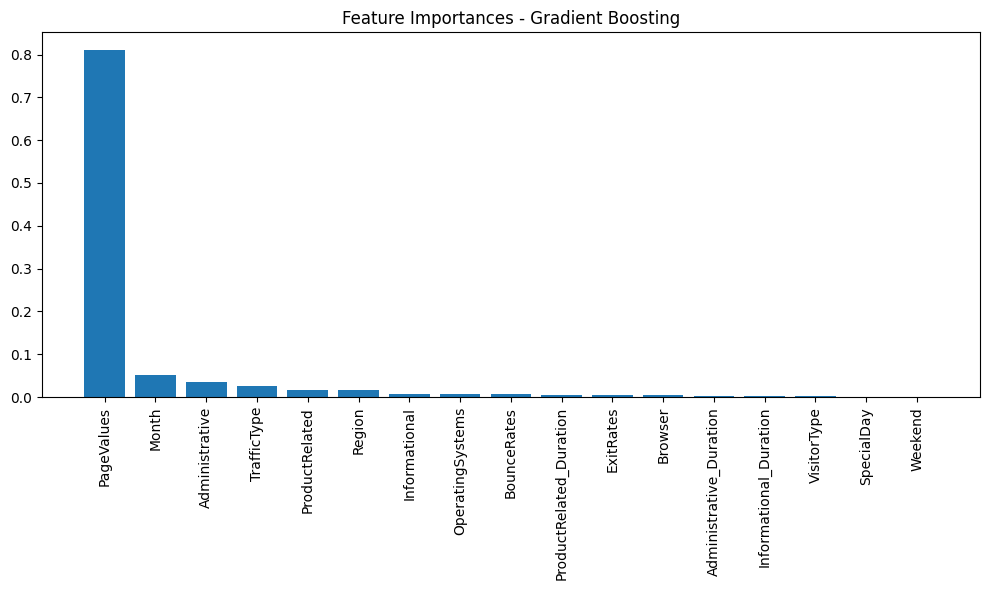

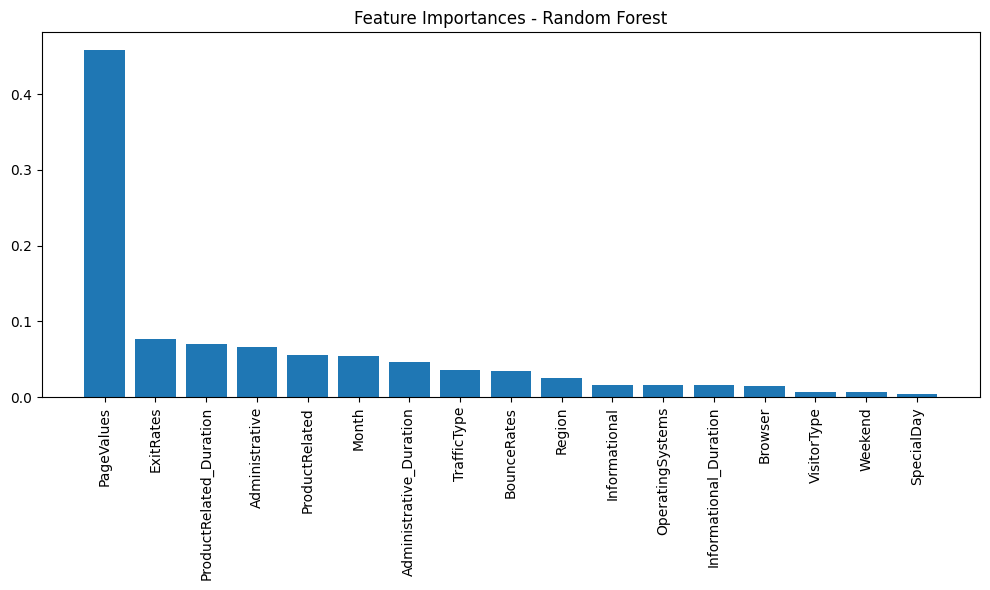

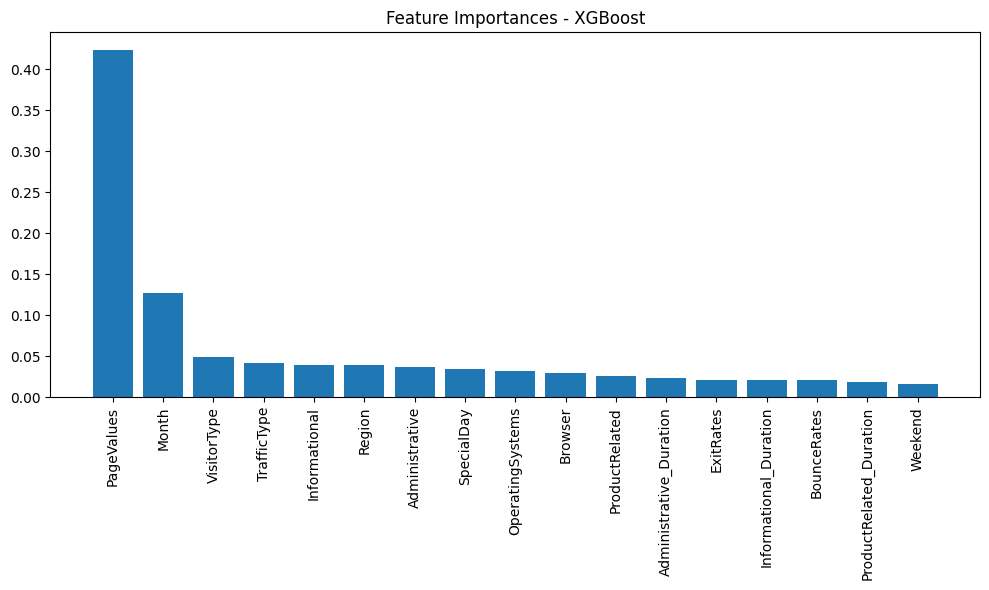

In [76]:
# Feature importance analysis for top 3 models
top_models = enhanced_results_df.nlargest(3, 'F1 Score').index
for model_name in top_models:
    if hasattr(enhanced_results[model_name]['Model'].named_steps['classifier'], 'feature_importances_'):
        importances = enhanced_results[model_name]['Model'].named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(X.shape[1]), importances[indices], align="center")
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

# Comparing original and enhanced models

In [77]:
# Combine results for comparison
comparison_df = pd.concat([
    results_df.add_prefix('Original_'),
    enhanced_results_df.add_prefix('Enhanced_')
], axis=1)

In [78]:
# Calculate improvements
comparison_df['F1_Improvement'] = comparison_df['Enhanced_F1 Score'] - comparison_df['Original_F1 Score']
comparison_df['ROC_AUC_Improvement'] = comparison_df['Enhanced_ROC AUC'] - comparison_df['Original_ROC AUC']

print("\nPerformance Improvement Comparison:")
print(comparison_df.sort_values(by='F1_Improvement', ascending=False))


Performance Improvement Comparison:
                     Original_Accuracy  Original_F1 Score  Original_ROC AUC  \
Logistic Regression           0.845904           0.579025          0.864408   
SVM                           0.861855           0.592829          0.853875   
Gradient Boosting             0.873479           0.646526          0.916881   
K-Nearest Neighbors           0.776156           0.467181          0.781853   
Random Forest                 0.881049           0.654631          0.910910   
XGBoost                       0.883482           0.645267          0.909627   
Naive Bayes                   0.556367           0.372467          0.798469   

                     Enhanced_Accuracy  Enhanced_F1 Score  Enhanced_ROC AUC  \
Logistic Regression           0.865639           0.623199          0.876137   
SVM                           0.864017           0.613374          0.870339   
Gradient Boosting             0.887808           0.666130          0.926279   
K-Nearest Neig

# Selecting best models

In [79]:
# Select best model based on enhanced results
best_model_name = enhanced_results_df['F1 Score'].idxmax()
best_model = enhanced_results[best_model_name]['Model']

print(f"\nBest performing model: {best_model_name}")
print(f"F1 Score: {enhanced_results_df.loc[best_model_name, 'F1 Score']:.4f}")
print(f"ROC AUC: {enhanced_results_df.loc[best_model_name, 'ROC AUC']:.4f}")



Best performing model: Gradient Boosting
F1 Score: 0.6661
ROC AUC: 0.9263
